In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load Spherical Features

In [2]:
file = 'area_3_data_pano_s2cnn_dims_128_128_16_16.mat'
data = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\"+file)
features = data["features"]
labels   = data["labels"][0]
print(features.shape)
print(labels.shape)
"""
# Truncate unnecessary objects in both datasets except chair.
# chair label is 2, see the list VALID_OBJECTS
indices  = np.argwhere(labels != 2)
features = np.delete(features, indices, axis=0)
labels   = np.delete(labels  , indices, axis=0)
print(features.shape)
print(labels.shape)
"""

(3141, 64)
(3141,)


'\n# Truncate unnecessary objects in both datasets except chair.\n# chair label is 2, see the list VALID_OBJECTS\nindices  = np.argwhere(labels != 2)\nfeatures = np.delete(features, indices, axis=0)\nlabels   = np.delete(labels  , indices, axis=0)\nprint(features.shape)\nprint(labels.shape)\n'

In [3]:
def visualize_scatter_2D(data_2d, labels, centers):
    fig = plt.figure(1, figsize=(10,8))
    title = 'Ground-truth 2D view with '+str(len(set(labels)))+' clusters'
    ax  = fig.add_subplot(1, 1, 1)
    if labels is not None:
        axs = ax.scatter(data_2d[:,0], data_2d[:,1], c=labels, s=10)
    else:
        axs = ax.scatter(data_2d[:,0], data_2d[:,1], marker='*', s=10)
    if centers is not None:
        axs = ax.scatter(centers[:0], centers[:1], marker='X', c='red', s=100)
        title = '2D view - '+str(len(centers)) + ' clusters'
    fig.colorbar(axs)
    ax.set_xlabel('X'), ax.set_ylabel('Y')
    ax.dist = 10
    plt.title(title)
    plt.show()
    
def visualize_scatter_3D(data_3d, labels, centers):
    fig = plt.figure(1, figsize=(10,8))
    title = 'Ground-truth 3D view with '+str(len(set(labels)))+' clusters'
    ax  = fig.add_subplot(1, 1, 1, projection='3d')
    if labels is not None:
        axs = ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], c=labels, s=10)        
    else:
        axs = ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], marker='*', s=10)
    if centers is not None:
        axs = ax.scatter(centers[0], centers[1], centers[2], marker='X', c='red', s=100)
        title = '3D view - '+str(len(centers)) + ' clusters'
    fig.colorbar(axs)
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
    ax.dist = 10
    plt.title(title)
    plt.show()

### Ground-truth with PCA & t-SNE

Text(0,0.5,'variance %')

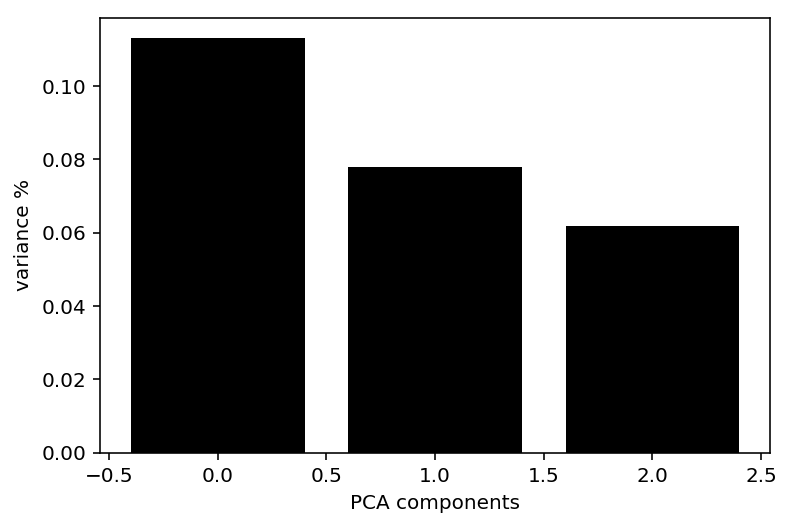

In [56]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
%config InlineBackend.figure_format='retina'

X = features
# Standardize the data to have a mean of ~0 and a variance of 1
X = StandardScaler().fit_transform(X)
X = normalize(X)

# Create a PCA instance
pca = PCA(n_components = 3)
PCA_components = pca.fit_transform(X)
#PCA_components = PCA_components[:,:3]

# Plot the explained variances
components = range(pca.n_components_)
plt.bar(components, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA components')
plt.ylabel('variance %')

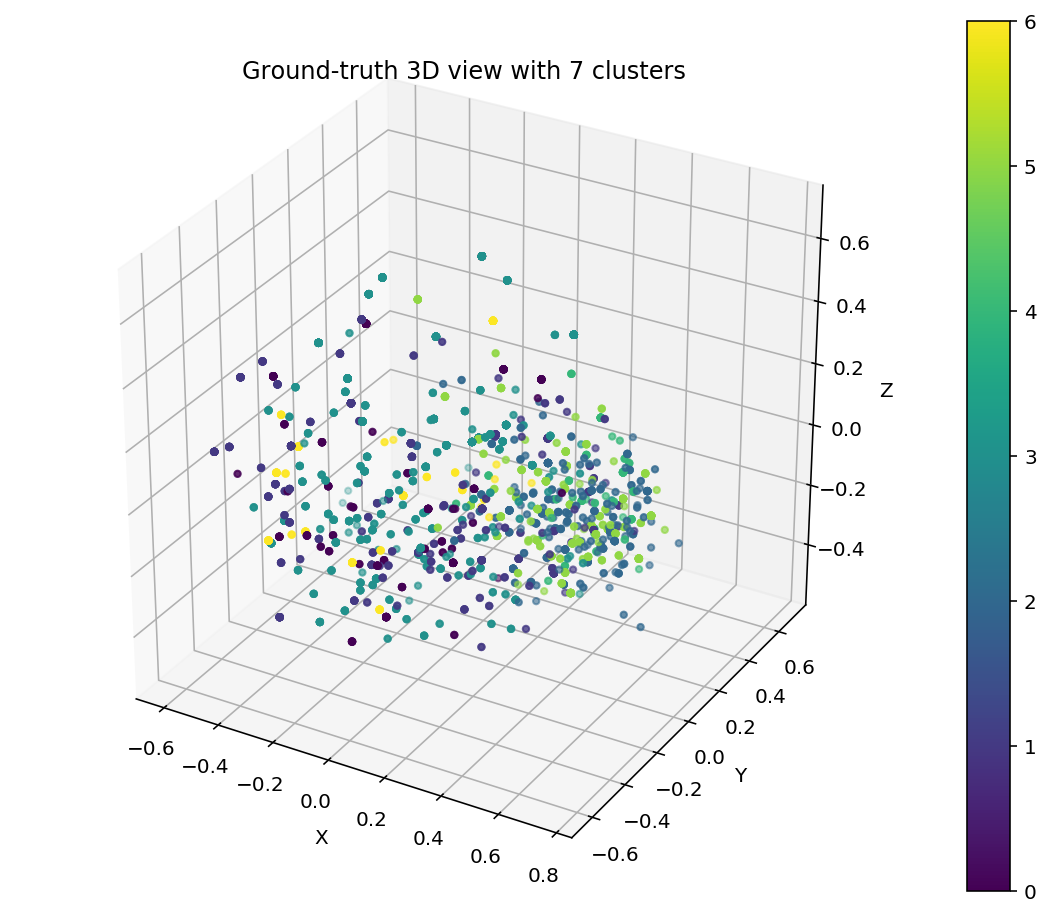

In [57]:
#%matplotlib widget
%matplotlib inline
visualize_scatter_3D(PCA_components, labels=labels, centers=None)

In [58]:

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components = 3)
tsne_result = tsne.fit_transform(PCA_components)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)


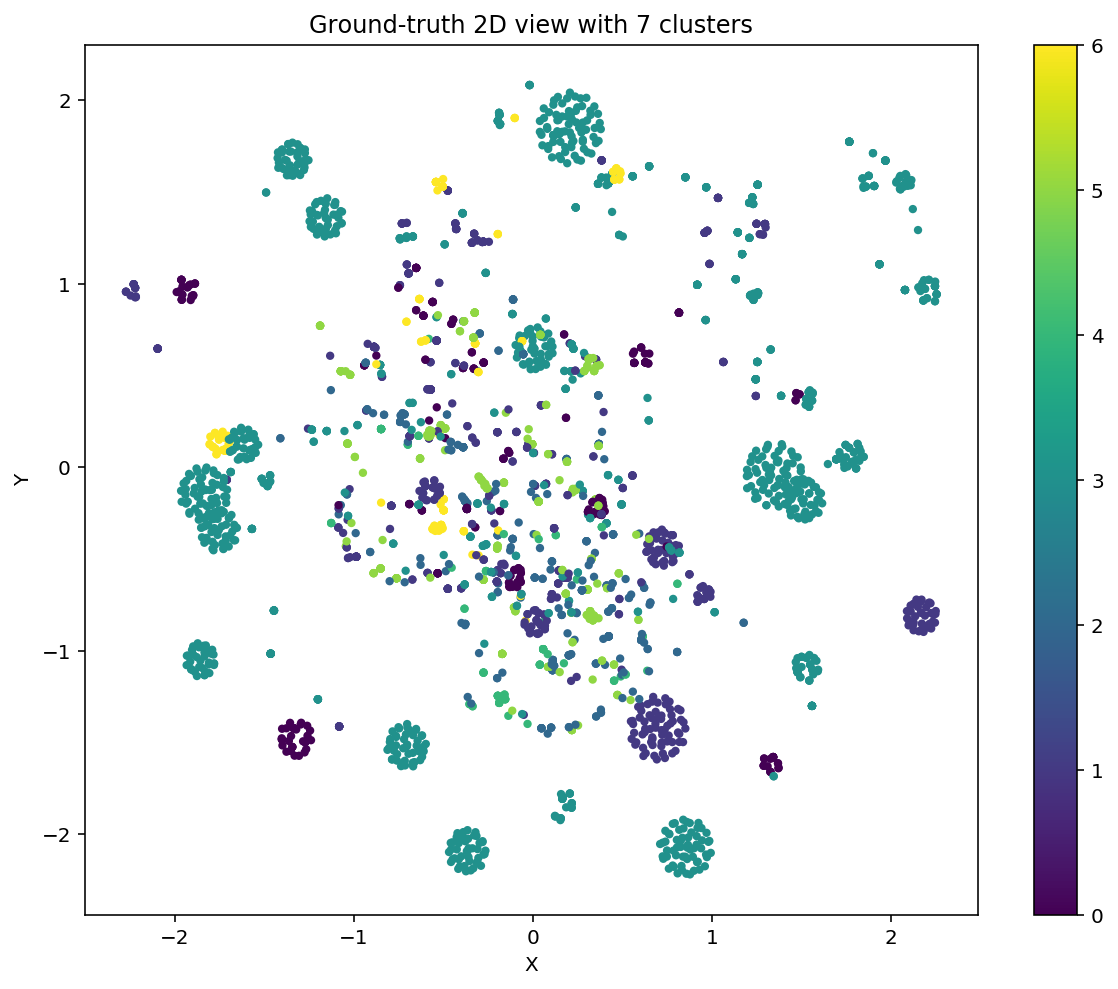

In [59]:
%matplotlib inline
visualize_scatter_2D(tsne_result_scaled, labels=labels, centers=None)

### K-Means

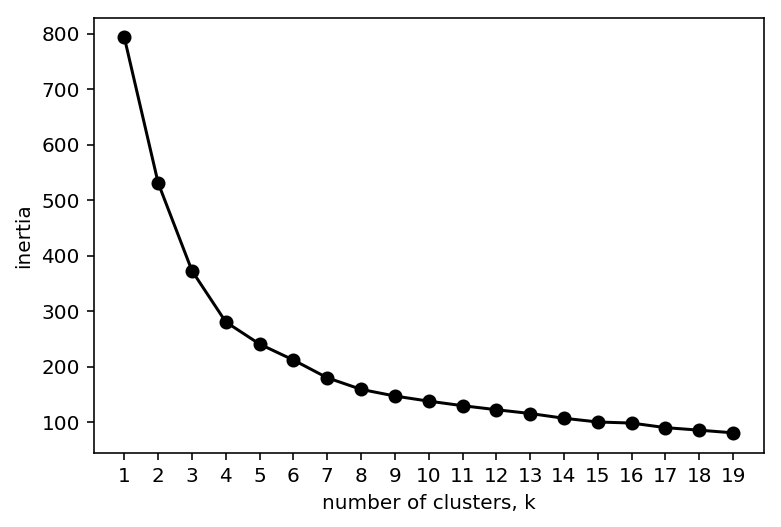

In [60]:
%matplotlib inline
from sklearn.cluster import KMeans

ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to first 10 components
    model.fit(PCA_components)
    #model.fit(tsne_result_scaled)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

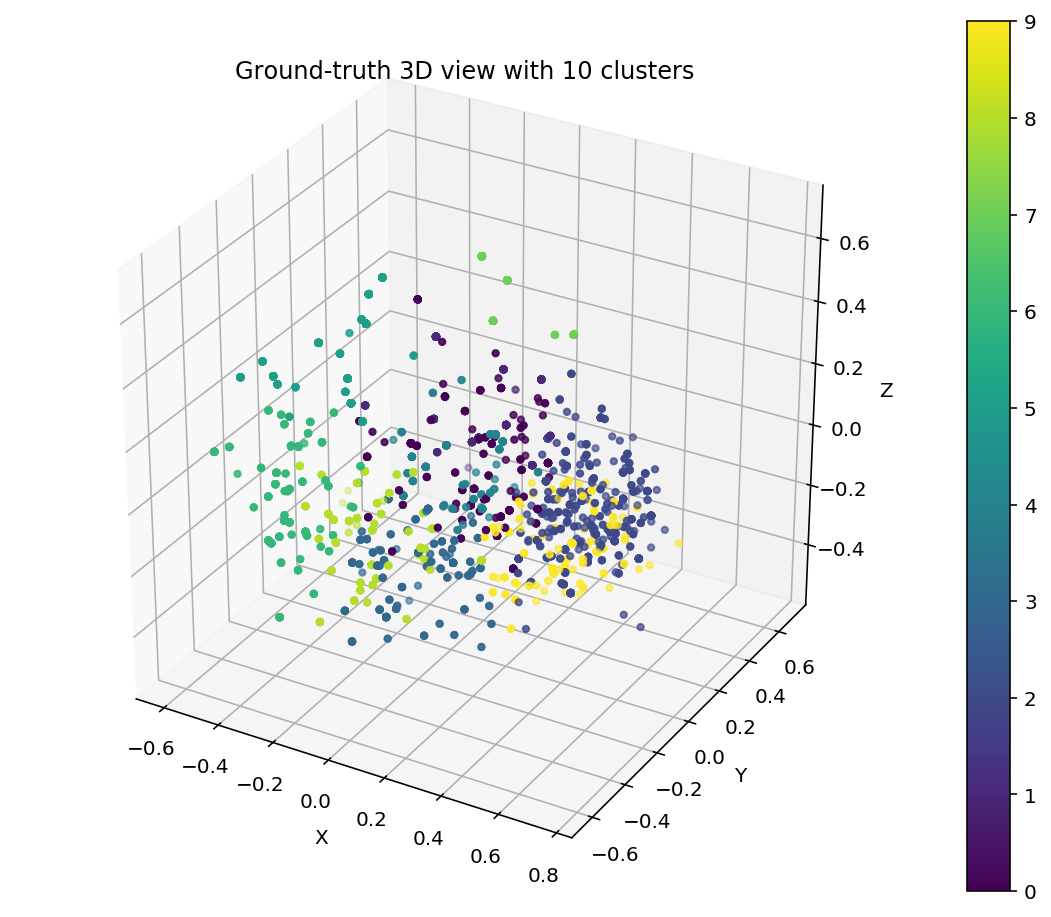

K-Means NMI score:  0.29650372875764824


In [61]:
%matplotlib inline
# Apply kmeans and plot 3D
n_clusters = 10
kmeans = KMeans(n_clusters).fit(PCA_components)
labels_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_
visualize_scatter_3D(PCA_components, labels_kmeans, None)

from sklearn.metrics.cluster import normalized_mutual_info_score
print('K-Means NMI score: ', normalized_mutual_info_score(labels, labels_kmeans))

### Agglomerative Hierarchical Clustering

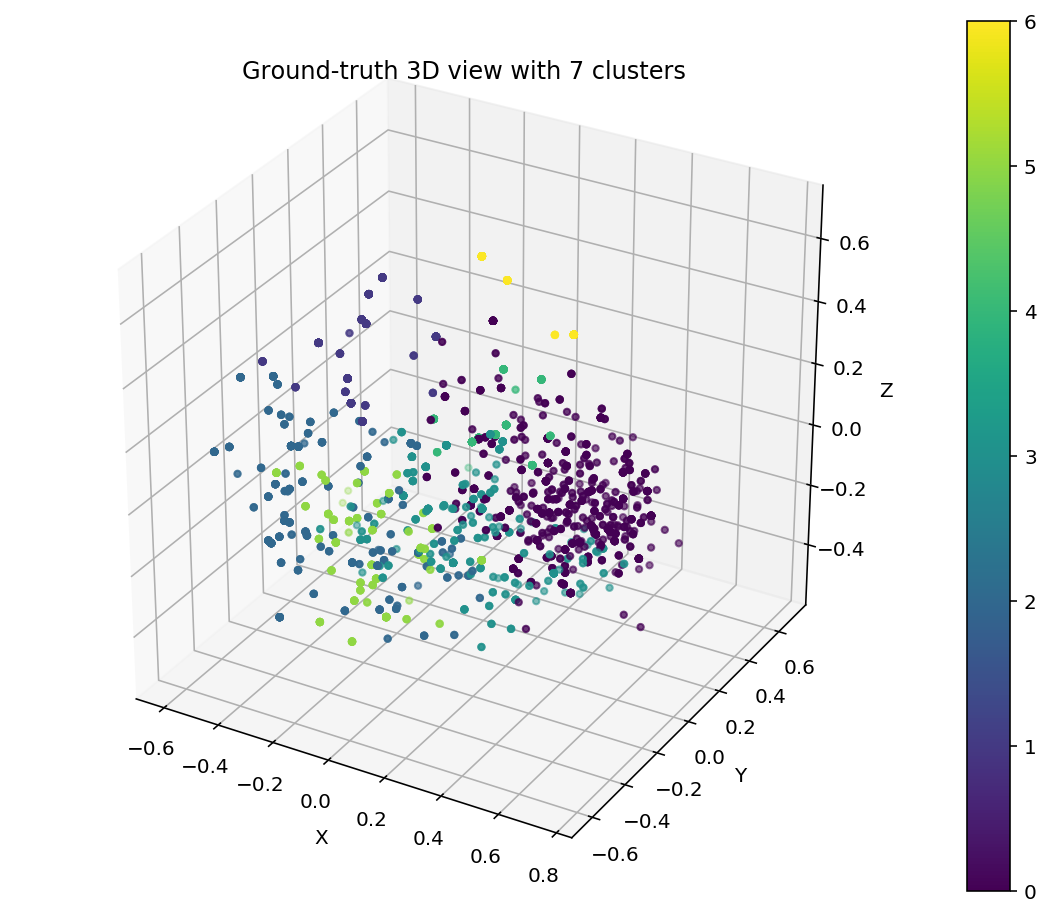

AgglomerativeClustering NMI score:  0.2708666615107227


In [62]:
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
n_clusters = 7
agc = AgglomerativeClustering(n_clusters)
labels_agc = agc.fit_predict(PCA_components)
visualize_scatter_3D(PCA_components, labels_agc, None)

from sklearn.metrics.cluster import normalized_mutual_info_score
print('AgglomerativeClustering NMI score: ', normalized_mutual_info_score(labels, labels_agc))

### Cosine similarity

In [63]:
f1, f2 = features[0], features[111]
l1, l2 = labels[0]  , labels[111]

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(features[10:15,:], dense_output=True)
print(cs.shape)
print(labels[10:15])

(5, 5)
[4 4 5 5 0]


In [65]:
cs

array([[1.0000001 , 0.9105652 , 0.92453235, 0.92453235, 0.8627512 ],
       [0.9105652 , 0.9999999 , 0.9678072 , 0.9678072 , 0.8860056 ],
       [0.92453235, 0.9678072 , 0.9999998 , 0.9999998 , 0.8564178 ],
       [0.92453235, 0.9678072 , 0.9999998 , 0.9999998 , 0.8564178 ],
       [0.8627512 , 0.8860056 , 0.8564178 , 0.8564178 , 0.9999998 ]],
      dtype=float32)

In [66]:
asd = PCA_components[0:5,:]
asd.shape

(5, 3)

In [67]:
import tensorflow as tf
# get similarity matrix
label_feat_norm = tf.nn.l2_normalize(asd, dim=1)
sim_mat = tf.matmul(label_feat_norm, label_feat_norm, transpose_b=True)
sess = tf.InteractiveSession()
cos_arr = sim_mat.eval()
cos_arr

array([[ 1.        ,  0.5351347 ,  0.7822158 ,  0.70285016,  0.5351373 ],
       [ 0.5351347 ,  0.9999999 ,  0.915394  , -0.08406872,  0.99999994],
       [ 0.7822158 ,  0.915394  ,  1.0000001 ,  0.32347584,  0.9153945 ],
       [ 0.70285016, -0.08406872,  0.32347584,  1.        , -0.08406723],
       [ 0.5351373 ,  0.99999994,  0.9153945 , -0.08406723,  1.        ]],
      dtype=float32)

In [68]:
pos_loc = tf.greater(sim_mat, 0.9, name='greater')
neg_loc = tf.less(sim_mat, 0.4, name='less')
# select_mask = tf.cast(tf.logical_or(pos_loc, neg_loc, name='mask'), dtype=tf.float32)
pos_loc_mask = tf.cast(pos_loc, dtype=tf.float32)
neg_loc_mask = tf.cast(neg_loc, dtype=tf.float32)

In [69]:
aa = pos_loc_mask.eval()
aa

array([[1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1.],
       [0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 1., 0., 1.]], dtype=float32)

In [70]:
# define losses and train op
pos_entropy = tf.multiply(-tf.log(tf.clip_by_value(sim_mat, eps, 1.0)), pos_loc_mask)
neg_entropy = tf.multiply(-tf.log(tf.clip_by_value(1-sim_mat, eps, 1.0)), neg_loc_mask)

NameError: name 'eps' is not defined